In [1]:
from utils import *
from preprocessing import *
from cnn_model import *
SIZE = 256

/home/jingxi/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
'''
# loading data and pre-process

'''
# original image, binary mask, contour(self-defined class)
img_train, mask_train, contour_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test, contour_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val, contour_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

#Region of interest, aka bounding box computed from the contour
ROI_train = get_ROI(contour_train)
ROI_test = get_ROI(contour_test)
ROI_val = get_ROI(contour_val)

#Re-organize the data for CNN
img_tv = np.concatenate((img_train, img_val), axis = 0)
roi_tv = np.concatenate((ROI_train, ROI_val), axis = 0)
print(img_tv.shape)
print(roi_tv.shape)

X, Y = reformDataXY(img_tv, roi_tv)
X_test, Y_test = reformDataXY(img_test, ROI_test)

#Get the result from the first step (CNN):

cnn_data = {'X_train': X, 'X_test': X_test, 'Y_train': Y, 'Y_test': Y_test}
y_pred = run_cnn(cnn_data)
cropped = get_cropped(img_test, y_pred, win_size = 100)

print(y_pred.shape)

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...

(526, 256, 256, 1)
(526, 32, 32)
(279, 1, 32, 32)


In [5]:
'''
#probably useless
def get_mask_roi_pred(img, y_pred, roi_size = 32):
    n = img.shape[0]
    mask_roi = np.zeros((n, 256, 256, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_roi[i] = cv2.rectangle(mask_roi[i], (x_max,y_max),(x_min,y_min),1,-1)*255   
    return mask_roi

mask_roi =get_mask_roi_pred(img_test,y_pred)
print(mask_roi.shape)
'''

In [7]:
#get predicted contour mask
def get_mask_pred(img,y_pred):
    n = img.shape[0]
    mask_contour = np.zeros((n, 80, 80, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_contour[i] =  img[i][x_min:x_max, y_min:y_max]   
    return mask_contour

mask_contour =get_mask_pred(mask_test,y_pred)
print(mask_contour.shape)

In [9]:
def open_data_AE(y_pred):
    """
    Open dataset from the output of the CNN and
    unroll it as 64*64 = vector of 4096 elements
    :param y_pred: CNN output
    :return: input AE, output
    """
    input_AE = []
    contour_experts = []
    for j in range(y_pred.shape[0]):
        in_AE = cv2.resize(cropped[j],(64 , 64))
        contour = cv2.resize(mask_contour[j], (64,64), interpolation = cv2.INTERSECT_NONE)
        input_AE.append(in_AE)
        contour_experts.append(contour)
    return np.array(input_AE).reshape((-1, 64*64)), np.array(contour_experts).reshape((-1, 64*64))

In [10]:
X_train, Y_train = open_data_AE(y_pred)
X_train.shape, Y_train.shape

((279, 4096), (279, 4096))

In [11]:
from StackedAeModel import SAE

/home/jingxi/.local/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [12]:
#apply stacked auto encoder to preprocessed data
h, model = SAE(X_train,Y_train)

Text(0.5,0,'epochs')

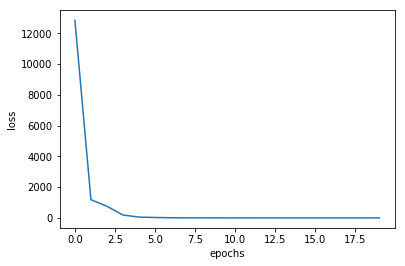

In [13]:
plt.plot(range(len(h)), h)
plt.ylabel('loss')
plt.xlabel('epochs')

In [35]:
def prediction_plot(X, model, idx):
    """
    Compute the Inferred shape binary mask using the trained stacked AE model
    :param X: dataset to predict
    :param model: trained AE model
    :param idx: index of the particular picture to return
    :return: inferred shape binary mask, infered shape on the MR image
    """
    contours = model.predict(X)
    contour = contours[idx].reshape((64,64))
    # thresholding
    binary = cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)
    return binary[1], binary[1]*X[idx].reshape(64,64)

In [36]:
#n is number of test images
n = img_test.shape[0]
pred_mask,pred_img=[],[]
for i in range(n):
    bin_mask,img = prediction_plot(X_train,model,i)
    pred_mask.append(bin_mask)
    pred_img.append(img)
pred_mask = np.array(pred_mask)
pred_img = np.array(pred_img)
print (pred_mask.shape)

(279, 64, 64)


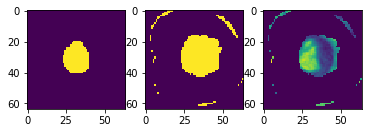

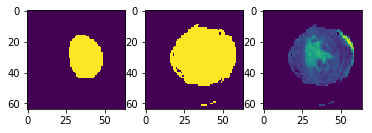

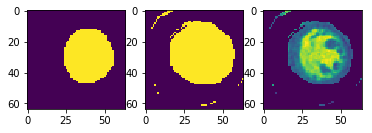

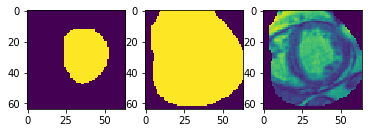

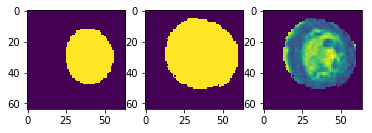

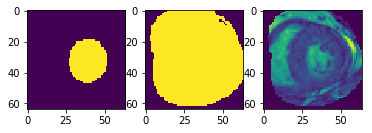

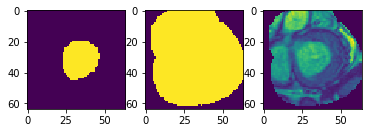

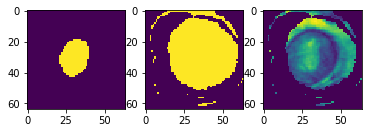

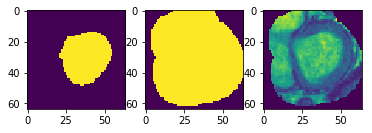

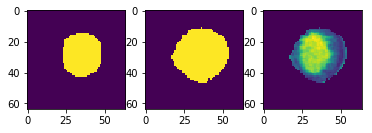

In [37]:
for i in range(10):
    plt.figure()
    plt.subplot(131)
    plt.imshow(Y_train[i].reshape((64,64)))
    plt.subplot(132)
    plt.imshow(pred_mask[i])
    plt.subplot(133)
    plt.imshow(pred_img[i])

In [27]:
#Metrics
def dice_metric(X, Y):
    return np.sum(X[Y==1])*2.0 / (np.sum(X) + np.sum(Y))

def conformity_coefficient(X, Y):
    return (3*dice_metric(X,Y)-2)/dice_metric(X,Y)

In [34]:
dm = np.zeros(n)
cc= np.zeros(n)
for i in range(n):
    Y_true = Y_train[i].reshape((64,64))
    dm[i] = dice_metric(pred_mask[i],Y_true)
    cc[i] = conformity_coefficient(pred_mask[i],Y_true)
#print(dm)

[0.1929107  0.55386351 0.78358531 0.41854637 0.68313393 0.29687082
 0.26533444 0.32945556 0.44096872 0.76763754 0.30410596 0.57206955
 0.06854716 0.06527652 0.73773266 0.48078267 0.47208402 0.25415871
 0.44991386 0.89695399 0.77796189 0.58897638 0.78907683 0.73653049
 0.05617284 0.34059098 0.82009404 0.7581156  0.78022192 0.67056277
 0.59433962 0.69717868 0.62052296 0.70790378 0.46912114 0.63111888
 0.73419773 0.75343284 0.78810122 0.7551305  0.45193017 0.79308289
 0.79215535 0.6873778  0.31968504 0.72213312 0.78937085 0.72609322
 0.0792663  0.6388309  0.60284153 0.55934252 0.63972034 0.59061012
 0.44593587 0.44762367 0.76291955 0.16409037 0.5559322  0.484375
 0.47649919 0.50502283 0.56810557 0.18409091 0.39010417 0.56842576
 0.42203219 0.52045297 0.45540608 0.49612403 0.63916176 0.45990099
 0.55517942 0.46544276 0.67549947 0.69957343 0.6402893  0.5394171
 0.28112231 0.52493075 0.4832978  0.65814295 0.06701506 0.46695402
 0.57979845 0.4256064  0.62432139 0.37585302 0.5893186  0.5395499

/home/jingxi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
